In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import shapefile
import flopy
from flopy.utils.gridgen import Gridgen
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridintersect import GridIntersect

In [2]:
model_ws = "../temp/structured/"

Load a few raster files

In [43]:
bottom = flopy.utils.Raster.load("../data_project/aquifer_bottom.asc")
top = flopy.utils.Raster.load("../data_project/aquifer_top.asc")
kaq = flopy.utils.Raster.load("../data_project/aquifer_k.asc")

Load a few shapefiles with geopandas

In [4]:
river = gpd.read_file("../data_project/Flowline_river.shp")
inactive = gpd.read_file("../data_project/inactive_area.shp")
active = gpd.read_file("../data_project/active_area.shp")
wells = gpd.read_file("../data_project/pumping_well_locations.shp")

#### Make a structured model grid

In [5]:
nlay, nrow, ncol = 3, 80, 40
shape2d, shape3d = (nrow, ncol), (nlay, nrow, ncol)
xlen, ylen = 5000., 10000.
delr = np.full(ncol, xlen / ncol, dtype=float)
delc = np.full(nrow, ylen / nrow, dtype=float)
ttop = np.full(shape2d, 1., dtype=float)
tbotm = np.full(shape3d, 0., dtype=float)

In [6]:
base_grid = StructuredGrid(delc=delc, delr=delr, nlay=1, nrow=nrow, ncol=ncol, top=ttop, botm=tbotm)

### Intersect the modelgrid with the shapefiles

#### Create an intersection object

In [7]:
ix = GridIntersect(base_grid, method="vertex", rtree=True)

#### Intersect inactive and active shapefiles with the modelgrid

After all of the intersection operations, take a look at the data contained in the returned objects

In [9]:
bedrock = ix.intersect(inactive.geometry[0])
active_cells = ix.intersect(active.geometry[0])

In [10]:
active_cells[:4], active_cells.dtype

(rec.array([((0, 0), (((125.0, 10000.0), (125.0, 9875.0), (0.0, 9875.0), (0.0, 10000.0), (125.0, 10000.0)),), 15625., <shapely.geometry.polygon.Polygon object at 0x164d5be80>),
            ((0, 1), (((250.0, 10000.0), (250.0, 9875.0), (125.0, 9875.0), (125.0, 10000.0), (250.0, 10000.0)),), 15625., <shapely.geometry.polygon.Polygon object at 0x164d5bd60>),
            ((0, 2), (((375.0, 10000.0), (375.0, 9875.0), (250.0, 9875.0), (250.0, 10000.0), (375.0, 10000.0)),), 15625., <shapely.geometry.polygon.Polygon object at 0x164d5bee0>),
            ((0, 3), (((500.0, 10000.0), (500.0, 9875.0), (375.0, 9875.0), (375.0, 10000.0), (500.0, 10000.0)),), 15625., <shapely.geometry.polygon.Polygon object at 0x164d5beb0>)],
           dtype=[('cellids', 'O'), ('vertices', 'O'), ('areas', '<f8'), ('ixshapes', 'O')]),
 dtype((numpy.record, [('cellids', 'O'), ('vertices', 'O'), ('areas', '<f8'), ('ixshapes', 'O')])))

#### Intersect well shapefile with the modelgrid

In [12]:
well_cells = []
for g in wells.geometry:
    v = ix.intersect(g)
    well_cells += v["cellids"].tolist()

In [13]:
well_cells

[(16, 30), (20, 24), (38, 26), (50, 18), (56, 10), (66, 22)]

#### Intersect river shapefile with the modelgrid

In [14]:
river_cells = ix.intersect(river.geometry[0])

In [15]:
river_cells[:4], river_cells.dtype

(rec.array([((0, 26), ((3347.2041259500543, 10000.0), (3355.5374592833878, 9875.0)), 125.27746982, <shapely.geometry.linestring.LineString object at 0x164d0da30>),
            ((1, 26), ((3355.5374592833878, 9875.0), (3363.5993485342024, 9754.071661237786), (3364.7968959570803, 9750.0)), 125.44088936, <shapely.geometry.linestring.LineString object at 0x164d0d4c0>),
            ((2, 26), ((3364.7968959570803, 9750.0), (3375.0, 9715.309446254074)),  36.15989286, <shapely.geometry.linestring.LineString object at 0x16512f970>),
            ((2, 27), ((3375.0, 9715.309446254074), (3401.5616018394335, 9625.0)),  94.13455675, <shapely.geometry.linestring.LineString object at 0x16512feb0>)],
           dtype=[('cellids', 'O'), ('vertices', 'O'), ('lengths', '<f8'), ('ixshapes', 'O')]),
 dtype((numpy.record, [('cellids', 'O'), ('vertices', 'O'), ('lengths', '<f8'), ('ixshapes', 'O')])))

### Intersect constant head line with the modelgrid

Use a line with two points to defined the location of the constant head cells. The line verticase are `[(1250, 0.1), (4250, 0.1)]`.

In [16]:
constant_cells = ix.intersect([(1250, 0.1), (4250, 0.1)], shapetype="linestring")

In [17]:
constant_cells[:4], constant_cells.dtype

(rec.array([((79, 10), ((1250.0, 0.1), (1375.0, 0.1)), 125., <shapely.geometry.linestring.LineString object at 0x164d0d940>),
            ((79, 11), ((1375.0, 0.1), (1500.0, 0.1)), 125., <shapely.geometry.linestring.LineString object at 0x16512f760>),
            ((79, 12), ((1500.0, 0.1), (1625.0, 0.1)), 125., <shapely.geometry.linestring.LineString object at 0x1651482b0>),
            ((79, 13), ((1625.0, 0.1), (1750.0, 0.1)), 125., <shapely.geometry.linestring.LineString object at 0x165148130>)],
           dtype=[('cellids', 'O'), ('vertices', 'O'), ('lengths', '<f8'), ('ixshapes', 'O')]),
 dtype((numpy.record, [('cellids', 'O'), ('vertices', 'O'), ('lengths', '<f8'), ('ixshapes', 'O')])))

### Resample the raster data to the modelgrid

Use the `resample_to_grid()` method on each raster object.

In [81]:
rtop = top.resample_to_grid(
    base_grid,
    band=top.bands[0],
    method="linear",
    extrapolate_edges=True,
)
rbot = bottom.resample_to_grid(
    base_grid,
    band=bottom.bands[0],
    method="linear",
    extrapolate_edges=True,
)
rkaq = kaq.resample_to_grid(
    base_grid,
    band=kaq.bands[0],
    method="linear",
    extrapolate_edges=True) * 86400.

### Plot the resampled data 

Plot the aquifer top, bottom, and hydraulic conductivity. Also plot the aquifer thickness.

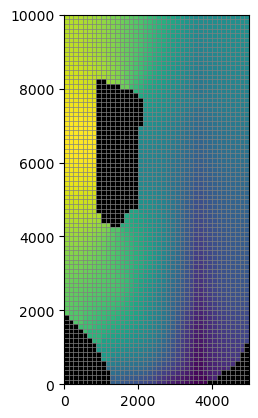

In [33]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
mm.plot_array(rtop)
mm.plot_grid(lw=0.5, color="0.5");
mm.plot_inactive(ibound=idomain[0]);

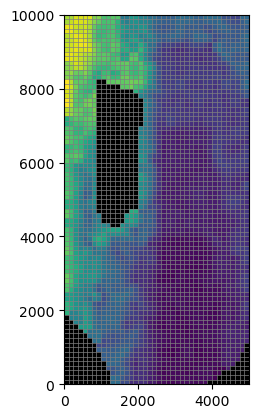

In [34]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
mm.plot_array(rbot)
mm.plot_grid(lw=0.5, color="0.5");
mm.plot_inactive(ibound=idomain[0]);

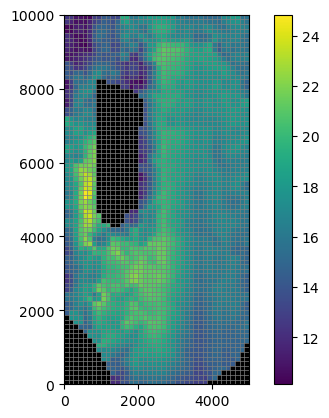

In [35]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
cb = mm.plot_array(rtop - rbot)
mm.plot_grid(lw=0.5, color="0.5");
mm.plot_inactive(ibound=idomain[0]);
plt.colorbar(cb);

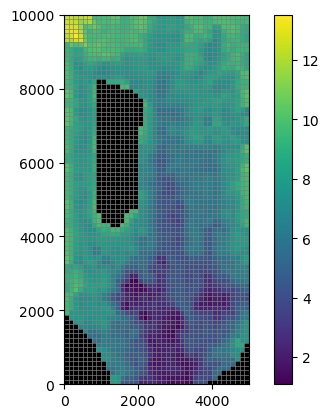

In [82]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
cb = mm.plot_array(rkaq)
mm.plot_grid(lw=0.5, color="0.5");
mm.plot_inactive(ibound=idomain[0]);
plt.colorbar(cb);

#### Build the model data

_Create the bottom of each model layer_

Assume that the thickness of each layer at a row, column location is equal.

In [37]:
botm = np.zeros(shape3d, dtype=float)
botm[-1, :, :] = rbot[:, :]
layer_thickness = (rtop - rbot) / nlay
for k in reversed(range(nlay - 1)):
    botm[k] = botm[k+1] + layer_thickness

_Create the idomain array_

Use the intersection data from the active and inactive shapefiles to create the idomain array

In [11]:
idomain = np.zeros((nlay, nrow, ncol), dtype=float)
for i, j in active_cells["cellids"]:
    idomain[:, i, j] = 1
for i, j in bedrock["cellids"]:
        idomain[:, i, j] = 0

_Build the well package stress period data_

* The pumping rates are in the `wells` geopandas dataframe
* Pumping rates are in m/sec
* The wells are located in model layer 3

In [83]:
wells

,FID,Q,geometry
0,0,-0.00820,POINT (3875.000 7875.000)
1,1,-0.00410,POINT (3125.000 7375.000)
2,2,-0.00390,POINT (3375.000 5125.000)
3,3,-0.00083,POINT (2375.000 3625.000)
4,4,-0.00072,POINT (1375.000 2875.000)
5,5,-0.00430,POINT (2875.000 1625.000)


In [85]:
well_spd = []
for (cellid, q) in zip(well_cells, wells["Q"]):
    well_spd.append([2] + list(cellid) + [q * 86400.])
well_spd

[[2, 16, 30, -708.48],
 [2, 20, 24, -354.24],
 [2, 38, 26, -336.96],
 [2, 50, 18, -71.712],
 [2, 56, 10, -62.208000000000006],
 [2, 66, 22, -371.52]]

_Build the river package stress period data_

* Calculate the length of the river using the `"lengths"` key. 
* The vertical hydraulic conductivity of the river bed sediments is 3.5 m/d.
* The thickness of river bottom sediments at the upstream (North) and downstream (South) end of the river is 1. and 2. meters, respectively. 
* The river bottom at the upstream and downstream end of the river is 20. and 10. meters, respectively. The river width at the upstream and downstream end of the river is 5.0 and 10.0 meters, respectively. 
* The river stage at the upstream and downstream end of the river is 20.1 and 11.0 meters, respectively.
* Use the boundname `upstream` for river cells where the upstream end of the river cell is less than 5000 m from the North end of the model. Use the boundname `downstream` for all other 

Use the upstream and downstream values to interpolate the river sediment thickness, bottom, width, and stage for each river cell.

The river cells will be conected to model layer 1. The river bottom, width, and stage values should be calculated at the center of the river reach.

In [57]:
river_kv = 3.5
river_kv

3.5

In [74]:
river_length = river_cells["lengths"].sum()
river_length

12419.290359618697

In [68]:
river_thickness_up, river_thickness_down = 1., 2.
river_thickness_slope = (river_thickness_down - river_thickness_up) / river_length

In [69]:
river_bot_up, river_bot_down = 20., 10.
river_bot_slope = (river_bot_down - river_bot_up) / river_length

In [70]:
river_width_up, river_width_down = 5., 10.
river_width_slope = (river_width_down - river_width_up) / river_length

In [71]:
stage_up, stage_down = 20.1, 11.0
stage_slope = (stage_down - stage_up) / river_length

In [80]:
boundname = "upstream"
total_length = 0.
river_spd = []
for idx, (cellid, length) in enumerate(zip(river_cells["cellids"], river_cells["lengths"])):
    if total_length >= 5000. and boundname == "upstream":
        boundname = "downstream"        
    dx = 0.5 * length
    total_length += dx
    river_thickness = river_thickness_up + river_thickness_slope * total_length
    river_bot = river_bot_up + river_bot_slope * total_length
    river_width = river_width_up + river_width_slope * total_length
    river_stage = stage_up + stage_slope * total_length
    conductance = river_kv * length * river_width / river_thickness
    river_spd.append([0] + list(cellid) + [river_stage, conductance, river_bot, boundname])
    total_length += dx
river_spd[:2], river_spd[-2:]

([[0,
   0,
   26,
   20.054102652311492,
   2192.355721846049,
   19.949563354188452,
   'upstream'],
  [0,
   1,
   26,
   19.96224808564778,
   2195.215563744797,
   19.84862426994261,
   'upstream']],
 [[0,
   78,
   25,
   11.121080400881803,
   1376.0871726713804,
   10.133055385584399,
   'downstream'],
  [0,
   79,
   25,
   11.046135888498174,
   2203.7499817606626,
   10.050698778569423,
   'downstream']])

_Build the constant head package stress period data_

